# Mobile Gaming A/B Testing

## Introduction

This project performs A/B testing on data from the game Cookie Cats, the data is sourced from kaggle. Cookie Cats is a popular puzzle mobile game developed by Tactile Entertainment. As of the time of this project it has over 1 million downloads on Google Play Store with a rating of 4.8. Like similar mobile games the player is time gated at certain stages to encourage them to make in-app purchases or wait until they can progress. 

The data is the result of trials performed by Tactile Entertainment on the first level a player encounters a time gate and their subsequent retention. Players are segmented into *Gate_30* or *Gate_40* - first gate encountered being at level 30 or 40. A/B test will be conducted on the data where the first gate was moved from level 30 to level 40.

## Table of Contents
- <b>1. Data Exploration</b>
- <b>2. Bootstrappping</b>
- <b>3. Statistical Models<br>
- <b>4. Conclusion

## 1. Data Exploration

<b>Imports.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from IPython.display import display, Image

import sys
sys.path.append("../scripts")
import some_functions # module used for notebook clarity

from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
from statsmodels.stats.proportion import proportions_ztest

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv("../input/cookie_cats.csv")

<b>Data Dictionary.

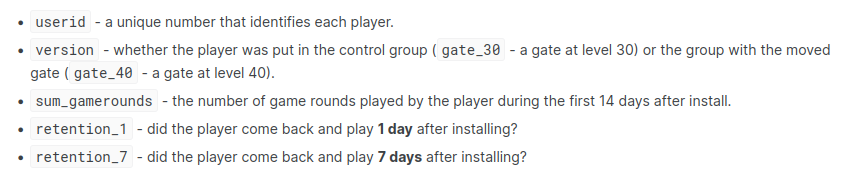

In [3]:
dict_path = "../input/data-dictionary.png"
display(Image(filename=dict_path))

<b>Data head.

In [4]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
df.shape

(90189, 5)

<b>There are no null values.

In [6]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

### <b>User Exploration
<b>The gate groups are fairly balanced user-wise.

In [7]:
print(f"Each entry is a unique user: {df.userid.nunique()} unique users, and {df.shape[0]} entries.")

Each entry is a unique user: 90189 unique users, and 90189 entries.


In [8]:
gate_30_df = df.query("version == 'gate_30'")
print(f"Users in gate_30: {gate_30_df.shape}")

gate_40_df = df.query("version == 'gate_40'")
print(f"Users in gate_40: {gate_40_df.shape}")

Users in gate_30: (44700, 5)
Users in gate_40: (45489, 5)


In [9]:
gate_40_df = df.query("version == 'gate_40'")
gate_40_df.shape

(45489, 5)

### <b>Gamerounds Exploration

<b>Sum Gamerounds exploration.<br>
<b>Is right skewed with outliers.

In [10]:
df.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

<b>3994 users have downloaded cookie cats but have yet to play a game of it. 

In [11]:
df_played = df[df["sum_gamerounds"]>0]
df_not_played = df[df["sum_gamerounds"]==0]
print("Number of users that downloaded the app but havent' played a games yet:", len(df_not_played))

Number of users that downloaded the app but havent' played a games yet: 3994


<b>These users that haven't played a game are fairly even spread over the gates.

In [12]:
df_not_played.version.value_counts()

version
gate_40    2057
gate_30    1937
Name: count, dtype: int64

<b>Some plotting shows that sum_gamerounds is right skewed as expected.

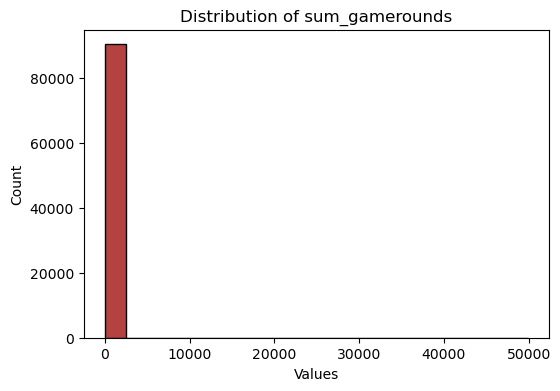

In [13]:
some_functions.basic_histo(df.sum_gamerounds,bins=20)

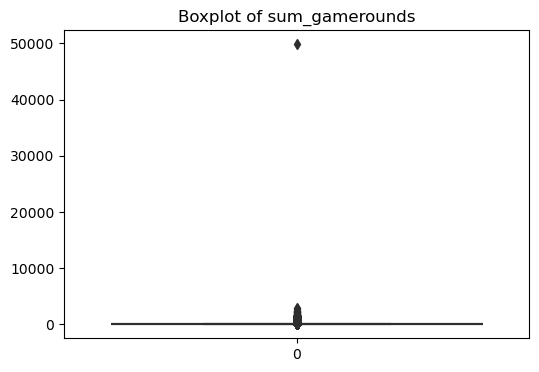

In [14]:
some_functions.basic_boxplot(df.sum_gamerounds)

<b>Log transformation helps to visualise it.

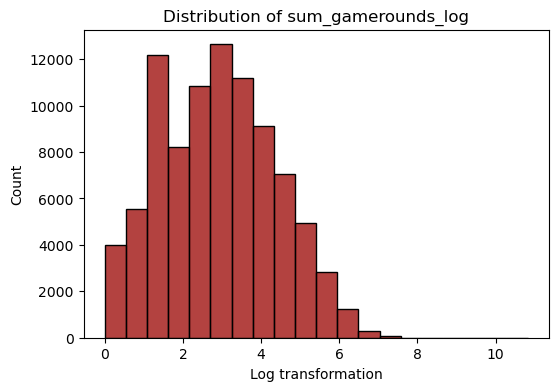

In [15]:
df['sum_gamerounds_log'] = np.log(df['sum_gamerounds']+1)
some_functions.basic_histo(df.sum_gamerounds_log, bins=20, values="Log transformation")

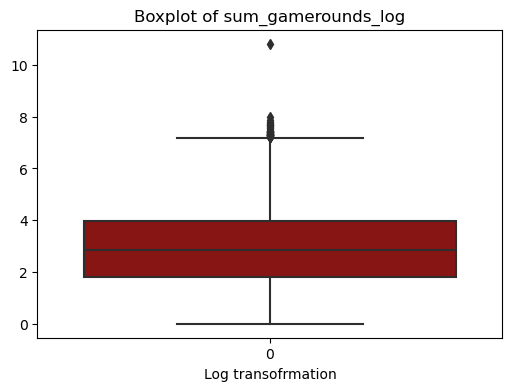

In [16]:
some_functions.basic_boxplot(df.sum_gamerounds_log, values="Log transofrmation")
df = df.drop("sum_gamerounds_log", axis=1)

### <b>Outlier investigation

<b>One user has played 49854 games, the next to him is 2961.

In [17]:
df.sort_values("sum_gamerounds", ascending=False).head()

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True


In [18]:
df_no_outlier = df[df['userid'] != 6390605]
df_no_outlier.sum_gamerounds.sort_values(ascending=False)

7912     2961
29417    2640
43671    2438
48188    2294
46344    2251
         ... 
59687       0
23707       0
59670       0
59645       0
45094       0
Name: sum_gamerounds, Length: 90188, dtype: int64

## 2. <b> Bootstrapping

<b>Bootstrapping is effective here and robust when there are outliers.

### 2.1. Retention_1

<b>The one day retention is 44% for the overall data.<br>
<b>The different gates have similar means.

In [19]:
print("Percent of users that play the day after installation:", df['retention_1'].mean())
print("")
display(df['retention_1'].value_counts())

Percent of users that play the day after installation: 0.4452095044850259



retention_1
False    50036
True     40153
Name: count, dtype: int64

In [20]:
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

<b>These distributions can be expanded on with bootstrapping.<br>
<b>With a small number of samples there isd .

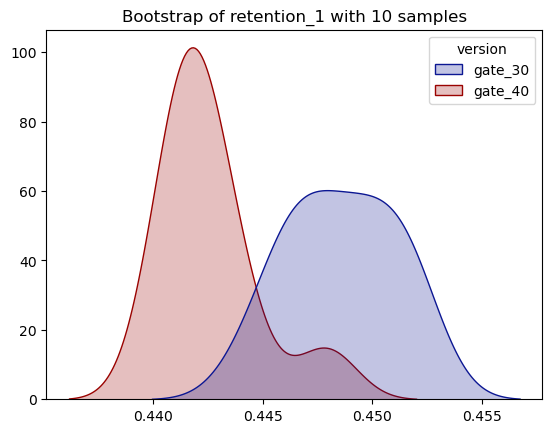

In [21]:
some_functions.basic_bootstrap(df, 10)

<b>With more sampling the distributions look more distinct.

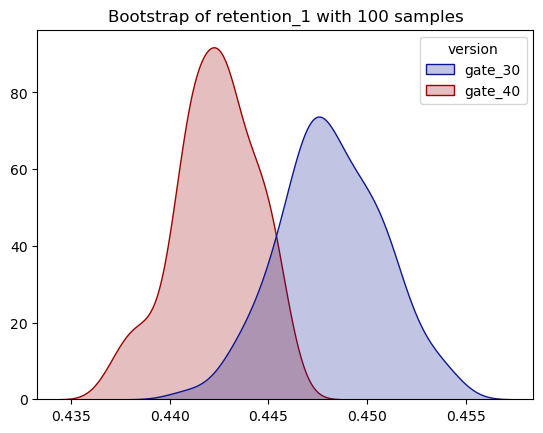

In [22]:
some_functions.basic_bootstrap(df, 100)

### 2.1. Retention_7

<b>7 day retention is lower than 1 day retention, and bootstrapping shows greater separation in the groups

In [23]:
print("Percent of users that play the day after installation:", df['retention_7'].mean())
print("")
display(df['retention_7'].value_counts())

Percent of users that play the day after installation: 0.1860648194347426



retention_7
False    73408
True     16781
Name: count, dtype: int64

In [24]:
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

<b>This time for 7 day retention and 100 samples greater difference in the means is seen.

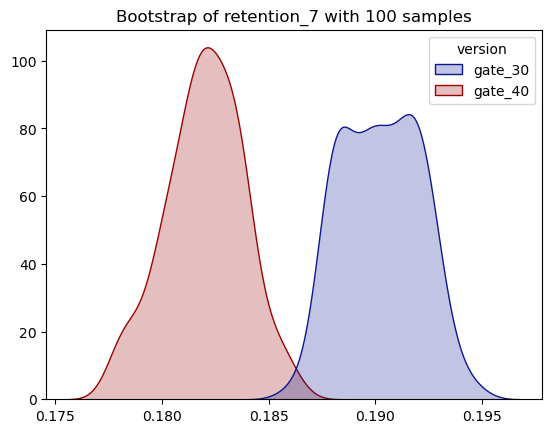

In [25]:
some_functions.basic_bootstrap(df, 100, x_value="retention_7")

## 3. Statistical Models

<b>Bootstapping seems to show a signifiance but to gather evidence statistical testing is needed, as the true mean of the sampels could exist in the overlap area.<br>

<b>These contingency tables will be used for Fisher's Exact test and Chi square, although we are more interested in the 7 day retention here.

In [26]:
contingency_table1 = pd.crosstab(df['version'], df['retention_1'])
display(contingency_table1)
contingency_table7 = pd.crosstab(df['version'], df['retention_7'])
display(contingency_table7)

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


### 3.1 Fishers Exact test

<b>Fishers Exact test is used with 2x2 contingency tables.<br>
<b>Although usually for small samples, it is ideal to understand if a significant difference exists, but doesn't comment on direction.<br>
<b>For Fisher's Exact test the following hypothesis will be stated:<br>
> H0: There is no significant difference in the true means of the samples, and we do not reject the null hypothesis.<br>
> Ha: There is a significant difference in the true means of the samples, and we have evidence to reject the null hypothesis.<br>

<b>Results:<br>
<b>For day one retention we do not have evidence to reject the null hypothesis.<br>
<b>For day seven retention we have evidence to reject the null hypothesis and support for the alternative hypothesis at 99% confidence.

In [27]:
odds_ratio, p_value = fisher_exact(contingency_table1)
print("Odds ratio:", odds_ratio)
print("P-value:", p_value)

Odds ratio: 0.976375742632873
P-value: 0.074707233724352


In [28]:
odds_ratio, p_value = fisher_exact(contingency_table7)
print("Odds ratio:", odds_ratio)
print("P-value:", p_value)

Odds ratio: 0.9472872405696028
P-value: 0.001590961583984235


### 3.2 Chi Square

<b>Chi square provides more of an approxmation than Fishers Exact test, but has uses when more categories.<br>
<b>It is more accurate for higher sample data, and will be done for example here.<br>
<b>Again, we state our hypothesis:<br>
> H0: There is no significant difference in the true means of the samples, and we do not reject the null hypothesis.<br>
> Ha: There is a significant difference in the true means of the samples, and we have evidence to reject the null hypothesis.<br>

<b>Results:<br>
<b>For day one retention we do not have evidence to reject the null hypothesis.<br>
<b>For day seven retention we have evidence to reject the null hypothesis and support for the alternative hypothesis at 99% confidence.

In [29]:
chi2_1, p_value_1, _, _ = chi2_contingency(contingency_table1)
print("P-value for Retention 1 Day:", p_value_1)
print("Observed Chi2 for Retention 1 days",chi2_1)

P-value for Retention 1 Day: 0.07550476210309086
Observed Chi2 for Retention 1 days 3.1591007878782262


In [30]:
chi2_2, p_value_7, _, _ = chi2_contingency(contingency_table7)
print("P-value for Retention 7 Days:", p_value_7)
print("Observed Chi2 for Retention 7 days",chi2_2)

P-value for Retention 7 Days: 0.0016005742679058301
Observed Chi2 for Retention 7 days 9.959086799559167


### 3.3 z-test for proportions

 <b>A z-test for proportions is carried out next.<b>
 <b>We can use 

> <b>H0: No difference in the means.<br>
> <b>Ha: The means come from different populations.

In [52]:
contingency_table7

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [67]:
successes = np.array([contingency_table7.iloc[0,1], contingency_table7.iloc[1,1]])
sample_sizes = np.array([len(gate_30_df), len(gate_40_df)])


#successes = np.array([contingency_table7.iloc[1,1], contingency_table7.iloc[0,1]])
#sample_sizes = np.array( [len(gate_40_df), len(gate_30_df)])

stat, pval = proportions_ztest(successes, sample_sizes)
print("Z-test statistic:", stat)
print("P-value:", pval)

Z-test statistic: 3.164358912748191
P-value: 0.001554249975614329


In [56]:
sample_sizes


array([44700, 45489])